# Anomaly detection on NYC Taxi data

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style = "whitegrid")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn import preprocessing

from sklearn.ensemble import IsolationForest

import nltk
import string
import re

%matplotlib inline

In [2]:
# Reading the input NYC taxi dataset

df = pd.read_csv("nyc_taxi.csv")

# Exploratory Data Analysis

In [3]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [4]:
df.describe()

,value
count,10320.000000
mean,15137.569380
std,6939.495808
min,8.000000
25%,10262.000000
50%,16778.000000
75%,19838.750000
max,39197.000000


In [5]:
df.shape

(10320, 2)

In [6]:
df.isnull().sum()

timestamp    0
value        0
dtype: int64

In [22]:
df['value'].value_counts()[:10]

18105    6
5410     5
17992    5
16700    5
18557    5
19670    5
2671     4
18814    4
20209    4
18093    4
Name: value, dtype: int64

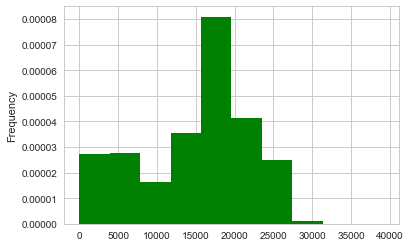

In [8]:
df.value.plot.hist(bins=10,density=True,color='green')

In [9]:
#Converting the date to timestamp

df['timestamp'] = pd.to_datetime(df['timestamp'])

In [10]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


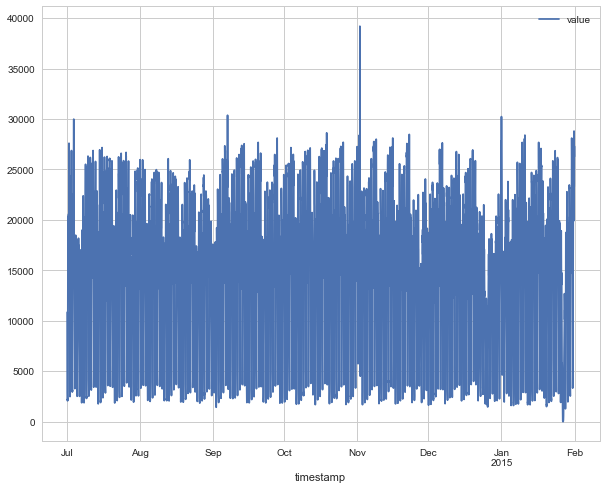

In [11]:
df.plot(x='timestamp',y='value',figsize=(10,8))

The anomalies seem to occur during the Thanksgiving season(November), and during the Christmas/New Year's Eve time

# Feature Engineering

In [12]:
df['Hours'] = df['timestamp'].dt.hour

In [13]:
df['Year'] = df['timestamp'].dt.year
df['Month'] = df['timestamp'].dt.month
df['Day'] = df['timestamp'].dt.day

In [14]:
df['Day_Of_Week'] = df['timestamp'].dt.dayofweek

In [19]:
df.head()

,timestamp,value,Hours,Year,Month,Day,Day_Of_Week
0,2014-07-01 00:00:00,10844,0,2014,7,1,1
1,2014-07-01 00:30:00,8127,0,2014,7,1,1
2,2014-07-01 01:00:00,6210,1,2014,7,1,1
3,2014-07-01 01:30:00,4656,1,2014,7,1,1
4,2014-07-01 02:00:00,3820,2,2014,7,1,1


In [20]:
df['Month'].value_counts()

7     1488
12    1488
10    1488
1     1488
8     1488
11    1440
9     1440
Name: Month, dtype: int64

In [23]:
df['Day_Of_Week'].value_counts()

5    1488
4    1488
3    1488
2    1488
1    1488
6    1440
0    1440
Name: Day_Of_Week, dtype: int64

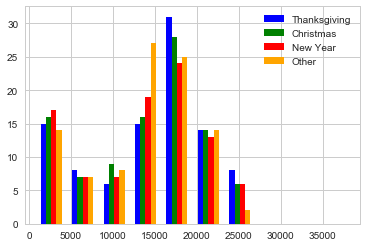

In [41]:
a = df.loc[df['Month'] == 11, 'value'] # November - Marathon+Thanksgiving
b = df.loc[df['Month'] == 12, 'value'] # Christmas
c = df.loc[df['Month'] == 1, 'value'] # New Year
d = df.loc[df['Month'] == 8, 'value'] 

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Thanksgiving')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Christmas')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='New Year')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='orange', label ='Other')

plt.legend()
plt.show()

# Isolation Forest

In [42]:
# Using Isolation Forest to detect anomalies
data = df[['value', 'Hours', 'Year', 'Month', 'Day_Of_Week']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = 0.01)
model.fit(data)
# add the data to the main  
df['anomaly'] = pd.Series(model.predict(data))
df['anomaly'] = df['anomaly'].map( {1: 0, -1: 1} )
print(df['anomaly'].value_counts())

0    10216
1      104
Name: anomaly, dtype: int64


In [34]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

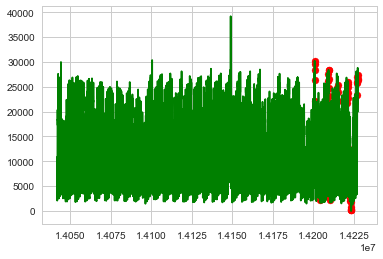

In [43]:
# visualisation of anomaly throughout time
fig, ax = plt.subplots()

a = df.loc[df['anomaly'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='green')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

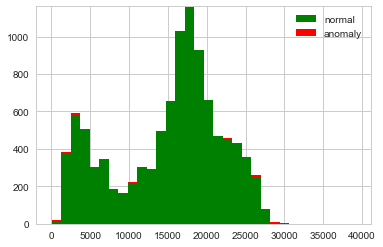

In [44]:
# visualisation of anomaly with number of customers
a = df.loc[df['anomaly'] == 0, 'value']
b = df.loc[df['anomaly'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['green', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()